# 1D CNN Segmentation Iberdrola Project - Phase 1

# Test GPU (Optional)
Before Starting, kindly check the available GPU from the Google Server, GPU model and other related information. It might help!

In [1]:
import torch
print("Is CUDA enabled GPU Available?", torch.cuda.is_available())
print("GPU Number:", torch.cuda.device_count())
print("Current GPU Index:", torch.cuda.current_device())
print("GPU Type:", torch.cuda.get_device_name(device=None))
print("GPU Capability:", torch.cuda.get_device_capability(device=None))
print("Is GPU Initialized yet?", torch.cuda.is_initialized())
print(torch.__version__)

Is CUDA enabled GPU Available? True
GPU Number: 1
Current GPU Index: 0
GPU Type: NVIDIA GeForce RTX 3080 Ti Laptop GPU
GPU Capability: (8, 6)
Is GPU Initialized yet? True
2.1.2+cu121


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())
print(tf.config.list_physical_devices('GPU'))

2025-03-14 18:51:50.430809: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 18:51:50.592072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741967510.660678    2667 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741967510.675428    2667 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 18:51:50.834523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Libraries

In [3]:
import os
import h5py
import scipy
import random
import pickle
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, root_mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr

In [4]:
# from segmentation_models import *
from segmentation_models.unet_variants import *
from segmentation_models.MLMRSNet import *
# from segmentation_models.saunet_variants import *

In [5]:
%matplotlib inline
sns.set_style('white')

# Set Number of Channels

In [11]:
num_channel = 3
fold = 1
device = 'Fridge'
phase = 1

# Import and Prepare Data

Import dataset

In [12]:
fl_Data = h5py.File(os.path.join('Raw_Data/Phase_1/04_Fridge_Data_Matched.mat'), 'r')
fl_Data.keys()

<KeysViewHDF5 ['data_appliance', 'data_appliance_raw', 'data_sm', 'data_sm_raw', 'house_number_array', 'normalization_factors']>

Prepare Dataset for Training

In [13]:
X_Data = np.swapaxes(np.array(fl_Data['data_sm']), 0, 2)
Y_Data = np.expand_dims(np.swapaxes(np.array(fl_Data['data_appliance']), 0, 1), axis=2)
house_label = np.squeeze(np.array(fl_Data['house_number_array']))
normalization_factors = np.squeeze(np.array(fl_Data['normalization_factors']))
print(X_Data.shape)
print(Y_Data.shape)
print(house_label.shape)
print(normalization_factors.shape)

(21600, 379, 3)
(21600, 379, 1)
(379,)
(12,)


In [14]:
X_Data_Subset = np.swapaxes(X_Data[:,:,0:3],0,1)
Y_Data_Subset = np.expand_dims(np.transpose(np.squeeze(Y_Data)),axis=2)
house_label_subset = house_label
X_Train1, X_Test, Y_Train1, Y_Test, house_label_Train1, house_label_Test = train_test_split(X_Data_Subset, Y_Data_Subset, house_label_subset, test_size=0.2, random_state=42)
X_Train, X_Val, Y_Train, Y_Val, house_label_Train, house_label_Val = train_test_split(X_Train1, Y_Train1, house_label_Train1, test_size=0.1, random_state=42)
print(X_Train1.shape)
print(Y_Train1.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(303, 21600, 3)
(303, 21600, 1)
(76, 21600, 3)
(76, 21600, 1)
(31, 21600, 3)
(31, 21600, 1)


Overlap Train Set

In [15]:
# Overlap
def overlap_data(X_Data, Y_Data, overlap_ratio, target_segment_length):
    # Input Array Shape
    X_Data_Shape = X_Data.shape
    Y_Data_Shape = Y_Data.shape
    original_segment_length = X_Data_Shape[1]
    # Reshape Array
    X_Data_Reshaped = np.reshape(X_Data, (X_Data_Shape[0]*X_Data_Shape[1], X_Data_Shape[2]))
    Y_Data_Reshaped = np.reshape(Y_Data, (X_Data_Shape[0]*X_Data_Shape[1], Y_Data_Shape[2]))
    X_Data_Reshaped_Shape = X_Data_Reshaped.shape
    Y_Data_Reshaped_Shape = Y_Data_Reshaped.shape
    # Overlap
    offset_amount = np.int_(original_segment_length*(1 - overlap_ratio))
    X_Data_New = np.zeros((10000,target_segment_length,X_Data_Reshaped_Shape[1]))
    Y_Data_New = np.zeros((10000,target_segment_length,Y_Data_Reshaped_Shape[1]))
    num_segments_approx = np.int_(np.ceil(X_Data_Reshaped_Shape[0]/offset_amount))
    counter = 0
    for i in range(0,num_segments_approx):
        if (i*offset_amount+target_segment_length) > X_Data_Reshaped_Shape[0]:
            continue
        X_Data_Temp = X_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        # X_Data_Temp = (X_Data_Temp - np.min(X_Data_Temp))/(np.max(X_Data_Temp)-np.min(X_Data_Temp))  # Range Normalization [0 1]
        X_Data_New[counter,:,:] = X_Data_Temp
        Y_Data_Temp = Y_Data_Reshaped[i*offset_amount:i*offset_amount+target_segment_length,:]
        # Y_Data_Temp = (Y_Data_Temp - np.min(Y_Data_Temp))/(np.max(Y_Data_Temp)-np.min(Y_Data_Temp))
        Y_Data_New[counter,:,:] = Y_Data_Temp
        counter = counter + 1
    X_Data_OVRL = X_Data_New[0:counter,:,:]
    Y_Data_OVRL = Y_Data_New[0:counter,:,:]
    
    return X_Data_OVRL, Y_Data_OVRL

In [16]:
X_Train, Y_Train = overlap_data(X_Train, Y_Train, 0.8, 21600)
# X_Test_OVRL, Y_Test_OVRL = overlap_data(X_Test, Y_Test, 0.9, 21600)
# X_Val_OVRL, Y_Val_OVRL = overlap_data(X_Val, Y_Val, 0.9, 21600)
print(X_Train.shape)
print(Y_Train.shape)
# print(X_Test_OVRL.shape)
# print(Y_Test_OVRL.shape)
# print(X_Val_OVRL.shape)
# print(Y_Val_OVRL.shape)

(1356, 21600, 3)
(1356, 21600, 1)


In [17]:
# Cleanse
def cleanse_data(X_Data, Y_Data):
    X_Data_Shape = X_Data.shape
    Y_Data_Shape = Y_Data.shape
    sample_num = X_Data_Shape[0]
    segment_length = X_Data_Shape[1]
    num_channels = X_Data_Shape[2]
    X_Data_Curated = np.zeros((sample_num,segment_length,num_channels))
    Y_Data_Curated = np.zeros((sample_num,segment_length,1))
    counter = 0
    for i in range(0,sample_num):
        X_Data_Temp = X_Data[i,:,:]
        Y_Data_Temp = Y_Data[i,:,:]
        Y_Data_Temp_VAR = np.var(Y_Data_Temp)
        if (Y_Data_Temp_VAR > 0.0001):
            X_Data_Curated[counter,:,:] = X_Data_Temp
            Y_Data_Curated[counter,:,:] = Y_Data_Temp
            counter = counter + 1
    X_Data_Curated = X_Data_Curated[0:counter,:,:]
    Y_Data_Curated = Y_Data_Curated[0:counter,:,:]
    
    return X_Data_Curated, Y_Data_Curated

In [18]:
X_Train, Y_Train = cleanse_data(X_Train, Y_Train)
X_Test, Y_Test = cleanse_data(X_Test, Y_Test)
X_Val, Y_Val = cleanse_data(X_Val, Y_Val)
print(X_Train.shape)
print(Y_Train.shape)
print(X_Test.shape)
print(Y_Test.shape)
print(X_Val.shape)
print(Y_Val.shape)

(1356, 21600, 3)
(1356, 21600, 1)
(76, 21600, 3)
(76, 21600, 1)
(31, 21600, 3)
(31, 21600, 1)


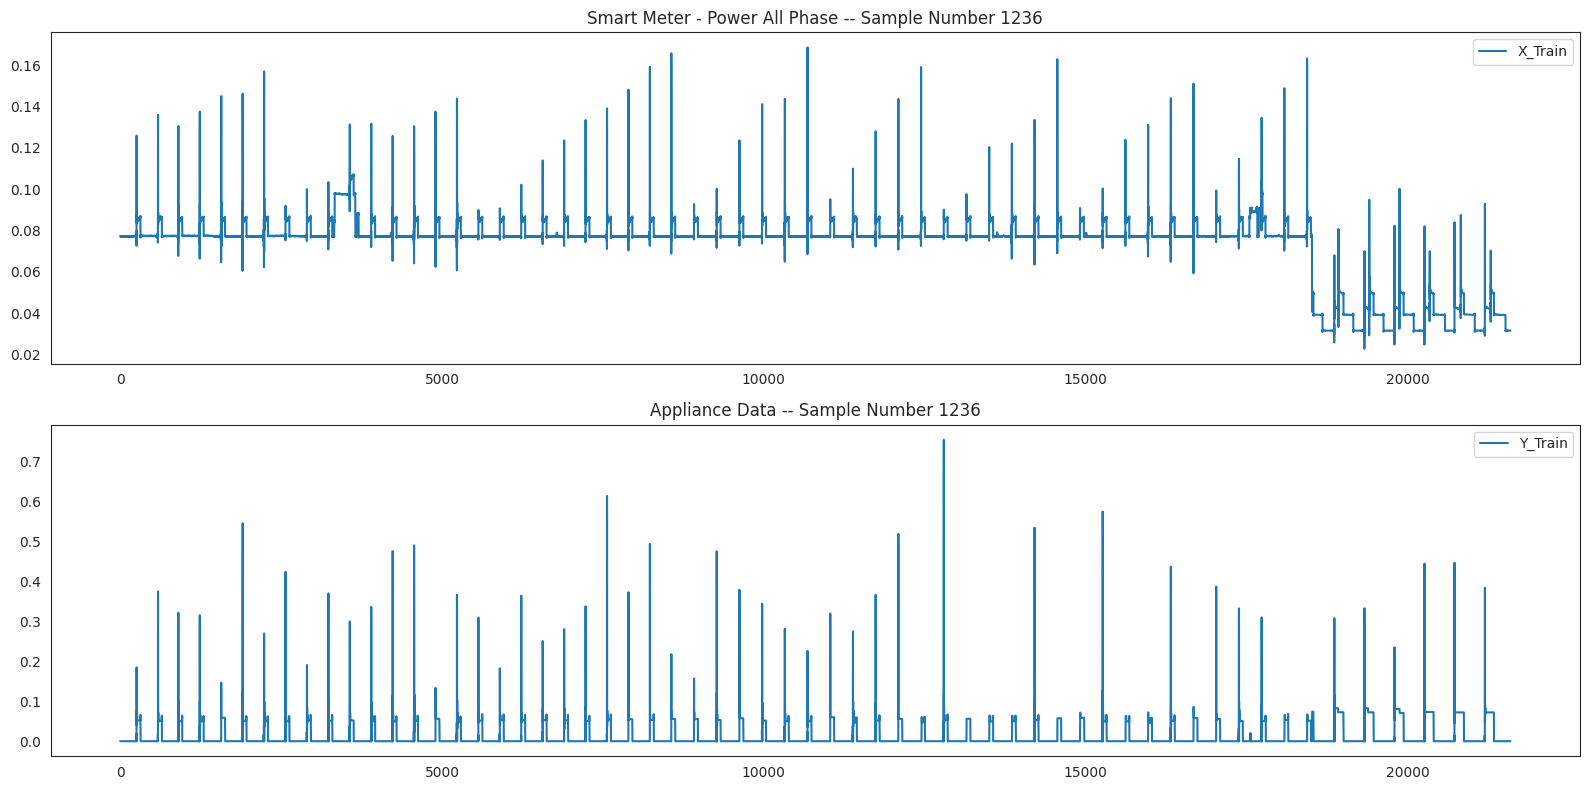

In [19]:
train_data_shape = Y_Train.shape
j = random.randint(0, train_data_shape[0])
A = X_Train[j,:,0]
C = Y_Train[j,:,0]
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plt.plot(A, label='X_Train')
plt.title(f"Smart Meter - Power All Phase -- Sample Number {j}")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(C, label='Y_Train')
plt.title(f"Appliance Data -- Sample Number {j}")
plt.tight_layout()
plt.legend()

In [20]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Train
Checkpoint['Y'] = Y_Train
RawDataPath = 'Train_Set.pt'
torch.save(Checkpoint, RawDataPath)

In [21]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Val
Checkpoint['Y'] = Y_Val
RawDataPath = 'Val_Set.pt'
torch.save(Checkpoint, RawDataPath)

In [22]:
import os
Checkpoint = {}
Checkpoint['X'] = X_Test
Checkpoint['Y'] = Y_Test
Checkpoint['Z'] = house_label_Test
Checkpoint['F'] = normalization_factors
RawDataPath = 'Test_Set.pt'
torch.save(Checkpoint, RawDataPath)

### Garbage Collector

In [ ]:
import gc #Garbage Collector
fl_Data = None
X_Test = None
X_Train = None
X_Val = None
Y_Test = None
Y_Train = None
Y_Val = None
gc.collect()

0

# MAIN

## Configurations

In [30]:
# Configurations
## General Configurations
signal_length = 21600  # Length of each Segment
model_name = 'LDNet'  # UNet, UNetPP, etc.
model_depth = 5  # Number of Level in the CNN Model
model_width = 32  # Width of the Initial Layer, subsequent layers start from here
kernel_size = 3  # Size of the Kernels/Filter
num_channel = 3 # Number of Channels in the Model
D_S = 1  # Turn on Deep Supervision
A_E = 0  # Turn on AutoEncoder Mode for Feature Extraction
A_G = 0  # Turn on for Guided Attention
LSTM = 0  # Turn on BiConvLSTM Block
problem_type = 'Regression'
output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
is_transconv = True # True: Transposed Convolution, False: UpSampling
feature_number = 1024  # Number of Features to be Extracted, only required if the AutoEncoder Mode is turned on

## Model Specific Configurations
alpha = 1  # Model Width Expansion Parameter, for MultiResUNet only
pooling_type = 'mix' # pooling_type, only for EMARS
cardinality = 5  # Cardinality, only for EMARS
q = 3
t = 1

## Data Configurations
DS_Model_Type = 'UNetPP' # UNet or UNetPP

## Experimental Configurations8
load_weights = False
max_epoch_stop = 20
max_epoch_lr_change = 10
lr = 3e-4
lr_factor = 0.1
monitor_param = 'loss'  # 'loss' or 'acc' for monitoring

# Loss Weight Dictionary for Deep Supervision
if D_S == 1:
    loss_weights = np.zeros(model_depth)
    for k in range(0, model_depth):
        loss_weights[k] = 1-(k*0.1)

## Helper Functions

In [32]:
def prepareTrainDict(batch_data, model_depth, model_name):
    def approximate(inp, w_len):
        ops = tf.keras.layers.AveragePooling1D(pool_size=w_len)(inp)
        return ops

    batch_data = np.array(batch_data)
    Y_Train_dict = {}
    Y_Train_dict['out'] = batch_data
    for i in range(1, (model_depth+1)):
        name = f'level{i}'
        if model_name == 'UNet':
            Y_Train_dict[name] = approximate(batch_data, 2**i)
        elif model_name == 'UNetPP':
            Y_Train_dict[name] = batch_data

    return Y_Train_dict

## Train and Test

Build Model for 1D Segmentation

In [24]:
# Build model for PPG2ABP Segmentation - Deep UNet Architecture
SMDisAgg_Network = UNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type='Regression', 
                        output_nums=output_nums, ds=D_S, ae=A_E, ag=A_G, lstm=LSTM, alpha=alpha, t=t, 
                        feature_number=feature_number, is_transconv=is_transconv, q=q).UNet4P()
# print(SMDisAgg_Network.summary())

In [33]:
# Build model for PPG2ABP Segmentation - Deep UNet Architecture
SMDisAgg_Network = MLMRSNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type='Regression', output_nums=output_nums,
                            ds=D_S, ae=A_E, cardinality=cardinality, pooling_type=pooling_type).LDNet()
# print(SMDisAgg_Network.summary())

In [ ]:
# Load Data
Train_Data = torch.load('Train_Set.pt')
Test_Data = torch.load('Test_Set.pt')
Val_Data = torch.load('Train_Set.pt')
X_Train = Train_Data['X']
Y_Train = Train_Data['Y']
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
X_Val = Val_Data['X']
Y_Val = Val_Data['Y']
if D_S == 0:  # Deep Supervision OFF
    # Compile Built Model
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=tf.keras.metrics.MeanSquaredError())
    # Directory for Saving Trained Models
    save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5'
    # Load Pretrained Weights (if available)
    if (os.path.exists(save_directory) and load_weights == True):
        print('\nLoading Pretrained Weights...')
        # Load Previously Trained Weights for Transfer Learning
        SMDisAgg_Network.load_weights(save_directory)
    # Declare Callbacks
    if monitor_param == 'loss':
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=max_epoch_stop, mode='min'),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=max_epoch_lr_change, verbose=1, mode='min'),
                    tf.keras.callbacks.ModelCheckpoint(save_directory, verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
    elif monitor_param == 'acc':
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=max_epoch_stop, mode='max'),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=lr_factor, patience=max_epoch_lr_change, verbose=1, mode='max'),
                    tf.keras.callbacks.ModelCheckpoint(save_directory, verbose=1, monitor='val_acc', save_best_only=True, mode='max')]
    # Train Model
    print('Starting Training...')
    model_history = SMDisAgg_Network.fit(X_Train, Y_Train, epochs=500, batch_size=1, verbose=1, validation_data=(X_Val, Y_Val), shuffle=True, callbacks=callbacks)
    # Test and Evaluation
    Y_Pred = SMDisAgg_Network.predict(X_Test, verbose=0)
    # Save History
    print('\n')
    print('Save History')
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = model_history.history
    history_path = f'Outcomes/{model_name}_{device}_History.h5'
    json.dump(history_dict.item(), open(history_path, 'w'))
    print('\n')
    # Save Outcomes
    print('Save Results')
    File = h5py.File(f'Outcomes/{model_name}_Ch{num_channel}_F{fold}_P{phase}_D{device}.h5', 'w')
    File.create_dataset('SM', data=X_Test)
    File.create_dataset('App', data=Y_Test)
    File.create_dataset('App_Pred', data=Y_Pred)
    File.close()
    print('\n')
elif D_S == 1:  # Deep Supervision ON
    # Prepare Train and Test Sets for Deep Supervision
    Y_Train_dict = prepareTrainDict(Y_Train, model_depth, DS_Model_Type)
    Y_Val_dict = prepareTrainDict(Y_Val, model_depth, DS_Model_Type)
    # Generate Custom Loss Weights for Deep Supervision
    loss_weights = {}
    keys = Y_Train_dict.keys()
    k = 0
    for key in keys:
        loss_weights[key] = 1-(k*0.1)
        k = k + 1
    #
    metrics_dic = []
    for i in range(0, model_depth + 1):
        metrics_dic.append(tf.keras.metrics.MeanSquaredError(name='mean_squared_error'))
    losses_dic = []
    for i in range(0, model_depth + 1):
        losses_dic.append(tf.keras.losses.Huber(delta=1.0, 
                                                reduction='sum_over_batch_size', 
                                                name='huber_loss'))
    # Compile Built Model
    SMDisAgg_Network.compile(loss=losses_dic, optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=metrics_dic, loss_weights=loss_weights)
    # Directory for Saving Trained Models
    save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.keras'
    # Load Pretrained Weights (if available)
    if (os.path.exists(save_directory) and load_weights == True):
        print('Loading Pretrained Weights...')
        # Load Previously Trained Weights for Transfer Learning
        SMDisAgg_Network.load_weights(save_directory)
    # Declare Callbacks
    if monitor_param == 'loss':
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_loss', patience=max_epoch_stop, mode='min'),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_out_loss', factor=lr_factor, patience=max_epoch_lr_change, verbose=1, mode='min'),
                    tf.keras.callbacks.ModelCheckpoint(save_directory, verbose=1, monitor='val_out_loss', save_best_only=True, mode='min')]
    elif monitor_param == 'acc':
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_out_acc', patience=max_epoch_stop, mode='max'),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_out_acc', factor=lr_factor, patience=max_epoch_lr_change, verbose=1, mode='max'),
                    tf.keras.callbacks.ModelCheckpoint(save_directory, verbose=1, monitor='val_out_acc', save_best_only=True, mode='max')]
    # Train Model
    print('Starting Training...')
    model_history = SMDisAgg_Network.fit(X_Train, Y_Train_dict, epochs=500, batch_size=2, verbose=1, validation_data=(X_Val, Y_Val_dict), shuffle=True, callbacks=callbacks)
    # Test and Evaluation
    Y_Pred = SMDisAgg_Network.predict(X_Test, verbose=0)
    Y_Pred = Y_Pred[0]
    '''Test and Evaluation'''
    # Save History
    print('\n')
    print('Save History')
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = model_history.history
    history_path = f'History/{model_name}_{device}_History.h5'
    with open(history_path, 'wb') as file:
        history_dict = model_history.history
        pickle.dump(history_dict, file, pickle.HIGHEST_PROTOCOL)
    print('\n')
    # Save Outcomes
    print('Save Results')
    File = h5py.File(f'Outcomes/{model_name}_Ch{num_channel}_F{fold}_P{phase}_{device}.h5', 'w')
    File.create_dataset('SM', data=X_Test)
    File.create_dataset('App', data=Y_Test)
    File.create_dataset('App_Pred', data=Y_Pred)
    File.close()
    print('\n')

In [ ]:
# Save History
print('\n')
print('Save History')
# Get the dictionary containing each metric and the loss for each epoch
history_dict = model_history.history
history_path = f'History/{model_name}_{device}_History.h5'
with open(history_path, 'wb') as file:
    history_dict = model_history.history
    pickle.dump(history_dict, file, pickle.HIGHEST_PROTOCOL)
print('\n')

Load History

In [ ]:
with open(history_path, 'rb') as file:
    history=pickle.load(file)
print(history.keys())

External Evaluation

In [ ]:
SMDisAgg_Network = MLMRSNet(signal_length, model_depth, num_channel, model_width, kernel_size, problem_type='Regression', output_nums=output_nums,
                            ds=D_S, ae=A_E, cardinality=cardinality, pooling_type=pooling_type).LDNet()
if D_S == 0:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError())
elif D_S == 1:
    SMDisAgg_Network.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=tf.keras.metrics.MeanSquaredError(), loss_weights= loss_weights)

In [11]:
# Load Model and Predict
save_directory = f'trained_models/{model_name}/'+model_name+'_'+str(signal_length)+'_'+str(model_width)+'_'+str(num_channel)+'_'+str(D_S)+'.h5'
SMDisAgg_Network.load_weights(save_directory)
# Load Test Set
Test_Data = torch.load('Test_Set.pt')
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
house_labels = Test_Data['Z']
print(X_Test.shape)
print(Y_Test.shape)
print(house_labels.shape)
# Predict
Y_Pred = SMDisAgg_Network.predict(X_Test, verbose=0)
Y_Pred = Y_Pred[0]
print(Y_Pred.shape)

(76, 21600, 3)
(76, 21600, 1)
(76,)


2024-05-30 18:05:13.704342: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-30 18:05:14.038925: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-30 18:05:14.282044: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(76, 21600, 1)


In [12]:
# Save Outcomes
print('Save Results')
File = h5py.File(f'Outcomes/{model_name}_Ch{num_channel}_F{fold}_P{phase}_{device}.h5', 'w')
File.create_dataset('SM', data=X_Test)
File.create_dataset('App', data=Y_Test)
File.create_dataset('App_Pred', data=Y_Pred)
File.close()
print('\n')

Save Results




In [22]:
# Load Resuts with Ground Truth and Inputs
fl_Data = h5py.File(os.path.join('Outcomes/LDNet_Ch3_F1_P1_Fridge.h5'),'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
# Y_Test_Denorm = fl_Data['App_Denorm']
# Y_Pred_Denorm = fl_Data['App_Pred_Denorm']

<KeysViewHDF5 ['App', 'App_Pred', 'SM']>


In [23]:
# Load Test Set and Print Shape
Test_Data = torch.load('Test_Set.pt')
X_Test = Test_Data['X']
Y_Test = Test_Data['Y']
house_labels = np.int16(Test_Data['Z'])
normalization_factors = Test_Data['F']
print(X_Test.shape)
print(Y_Test.shape)
print(house_labels.shape)
print(normalization_factors.shape)
house_labels_unique = np.unique(house_labels)
num_houses = np.size(house_labels_unique)
# Denormalize Waveforms for Evaluation
Y_Test_shape = Y_Test.shape
Y_Test_Denorm = np.zeros((Y_Test_shape[0],Y_Test_shape[1],Y_Test_shape[2]))
for i in range(Y_Test_shape[0]):
    Y_Test_Norm_Temp = Y_Test[i,:,:]
    house_label_Temp = house_labels[0]
    Y_Test_Denorm_Temp = Y_Test_Norm_Temp*normalization_factors[house_label_Temp*2-2]
    Y_Test_Denorm[i,:,:] = Y_Test_Denorm_Temp
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/LDNet_Ch3_F1_P1_Fridge.h5'), 'r')
print(fl_Data.keys())
Y_Pred = fl_Data['App_Pred']
Y_Pred_shape = Y_Pred.shape
Y_Pred_Denorm = np.zeros((Y_Pred_shape[0],Y_Pred_shape[1],Y_Pred_shape[2]))
for i in range(Y_Pred_shape[0]):
    Y_Pred_Norm_Temp = Y_Pred[i,:,:]
    house_label_Temp = house_labels[0]
    Y_Pred_Denorm_Temp = Y_Pred_Norm_Temp*(normalization_factors[house_label_Temp*2-2])
    Y_Pred_Denorm[i,:,:] = Y_Pred_Denorm_Temp

(76, 21600, 3)
(76, 21600, 1)
(76,)
(12,)
<KeysViewHDF5 ['App', 'App_Pred', 'SM']>


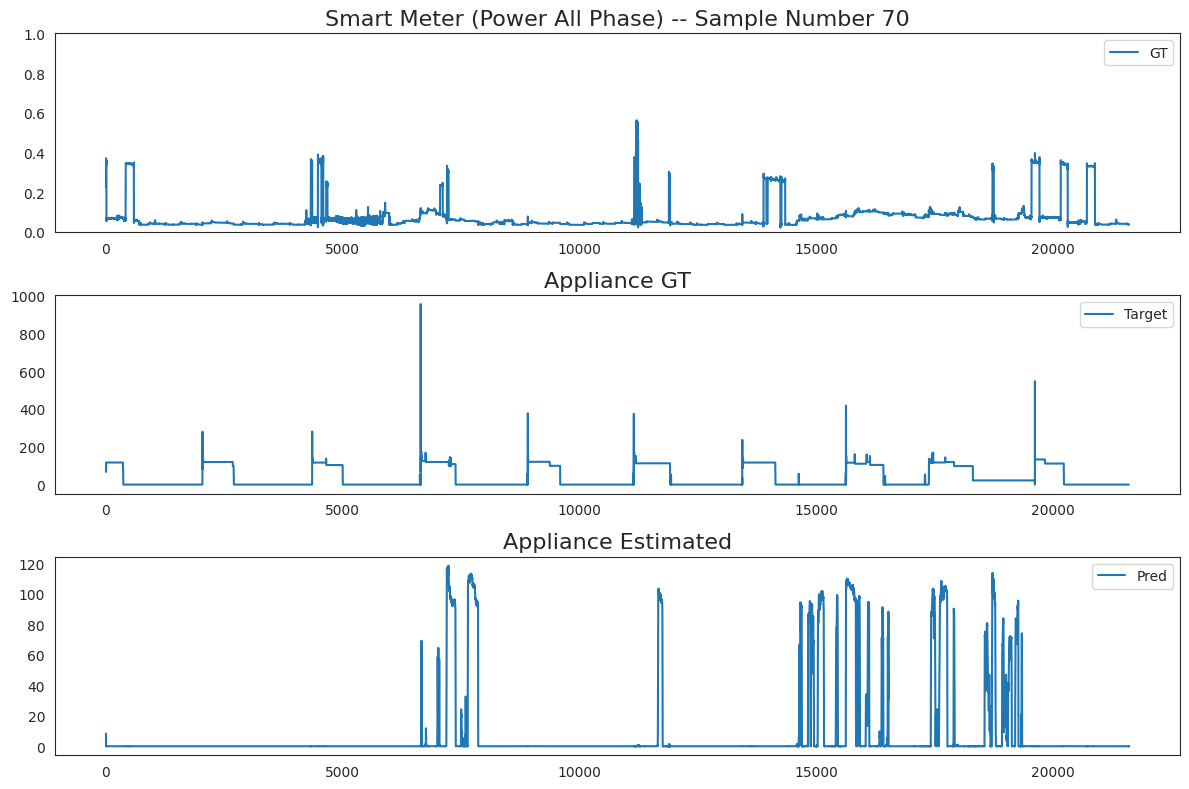

In [42]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(X_Test[i,:,0], label='GT')
plt.ylim(0,1)
plt.title(f"Smart Meter (Power All Phase) -- Sample Number {i}", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,2)
plt.plot(Y_Test_Denorm[i,:,0], label='Target')
# plt.ylim(0,1)
plt.title(f"Appliance GT", fontdict={'fontsize': 16})
plt.legend()
plt.subplot(3,1,3)
plt.plot(Y_Pred_Denorm[i,:,0], label='Pred')
# plt.ylim(0,1)
plt.title(f"Appliance Estimated", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

In [25]:
# Save Outcomes
print('Saving Results')
File = h5py.File(f'Outcomes/LDNet_5_32_DS_Fridge_SM3_21600_Overlapped.h5', 'w')
File.create_dataset('SM', data=X_Test)
File.create_dataset('App', data=Y_Test)
File.create_dataset('App_Pred', data=Y_Pred)
File.create_dataset('App_Denorm', data=Y_Test_Denorm)
File.create_dataset('App_Pred_Denorm', data=Y_Pred_Denorm)
File.close()

Saving Results


# Evaluated

Load Data

In [53]:
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/LDNet/LDNet_5_32_DS_Dishwasher_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


Construction Errors

In [26]:
def Construction_Error(GRND, Pred):
    mae_construction_err = []
    mse_construction_err = []
    rmse_construction_err = []
    cc = []
    for i in range(len(GRND)):
        MAE = np.mean(np.abs(Pred[i].ravel() - GRND[i].ravel()))
        MSE = mean_squared_error(Pred[i].ravel(), GRND[i].ravel())
        RMSE = root_mean_squared_error(Pred[i].ravel(), GRND[i].ravel())
        if ~(np.std(Pred[i].ravel()) == 0 or np.std(GRND[i].ravel()) == 0):
            corr, _ = pearsonr(Pred[i].ravel(), GRND[i].ravel())
        else:
            continue
        mae_construction_err.append(MAE)
        mse_construction_err.append(MSE)
        rmse_construction_err.append(RMSE)
        cc.append(corr)
    print(f'MAE Construction Error: {round(np.mean(mae_construction_err), 3)} +/- {round(np.std(mae_construction_err), 3)}')
    print(f'MSE Construction Error: {round(np.mean(mse_construction_err), 3)} +/- {round(np.std(mse_construction_err), 3)}')
    print(f'RMSE Construction Error: {round(np.mean(rmse_construction_err), 3)} +/- {round(np.std(rmse_construction_err), 3)}')
    print(f'Pearson Correlation: {round(np.mean(cc)*100, 3)}% +/- {round(np.std(cc)*100, 3)}')
    MAE = round(np.mean(mae_construction_err), 3)
    MSE = round(np.mean(mse_construction_err), 3)
    RMSE = round(np.mean(rmse_construction_err), 3)
    PCC = round(np.mean(cc)*100, 3)
    return MAE, MSE, RMSE, PCC

In [27]:
Construction_Error(Y_Pred_Denorm, Y_Test_Denorm)

MAE Construction Error: 21.508 +/- 15.905
MSE Construction Error: 2374.642 +/- 1911.063
RMSE Construction Error: 44.13 +/- 20.669
Pearson Correlation: 57.792% +/- 32.321


(21.508, 2374.642, 44.13, 57.792)

SAE

In [28]:
def Calculate_SAE(GRND, Pred):
    EP = 0
    EG = 0

    for i in range(len(GRND)):
        EG = EG + np.sum(GRND[i].ravel())
        EP = EP + np.sum(Pred[i].ravel())
        
    SAE = np.abs(EP - EG)/EG
    print(f'SAE Construction Error: {round(SAE, 3)}')
    return SAE

In [29]:
Calculate_SAE(Y_Test_Denorm, Y_Pred_Denorm)

SAE Construction Error: 0.334


0.3337912683257497

EA

In [30]:
def Calculate_EA(GRND, Pred):
    EA = []
    for i in range(len(GRND)):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        NOM_Temp_TOT = 0
        DENOM_Temp_TOT = 2*(np.sum(GRND_Temp))
        for ii in range(len(GRND_Temp)):
            NOM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            NOM_Temp_TOT = NOM_Temp_TOT + NOM_Temp
        NOM_Temp = 1 - (NOM_Temp_TOT/DENOM_Temp_TOT)
        EA.append(NOM_Temp)
    EA_OVR = round(np.mean(EA), 3)
    print(f'Estimation Accuracy (EA): {EA_OVR}')

In [31]:
Calculate_EA(Y_Test_Denorm, Y_Pred_Denorm)

Estimation Accuracy (EA): 0.724


JEOI

In [32]:
def Calculate_JEOI(GRND, Pred):
    JEOI = []
    for i in range(len(GRND)):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        EP_Temp_TOT = np.sum(Pred_Temp)
        EG_Temp_TOT = np.sum(GRND_Temp)
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
            
        EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        JEOI_Temp = EO_Temp_TOT/(EO_Temp_TOT+EE_Temp_TOT+EM_Temp_TOT)
        JEOI.append(JEOI_Temp)
    JEOI_OVR = round(np.mean(JEOI), 4)
    print(f'JEOI: {JEOI_OVR}')
    return JEOI_OVR

In [33]:
Calculate_JEOI(Y_Test_Denorm, Y_Pred_Denorm)

JEOI: 0.502


0.502

DEOI

In [35]:
def Calculate_DEOI(GRND, Pred):
    DEOI = []
    for i in range(len(GRND)):
        GRND_Temp = GRND[i].ravel()
        Pred_Temp = Pred[i].ravel()
        EO_Temp_TOT = 0
        EE_Temp_TOT = 0
        EM_Temp_TOT = 0
        EP_Temp_TOT = np.sum(Pred_Temp)
        EG_Temp_TOT = np.sum(GRND_Temp)
        for ii in range(len(GRND_Temp)):
            if Pred_Temp[ii] < 0:
                Pred_Temp[ii] = 0
            if GRND_Temp[ii] > Pred_Temp[ii]:
                EO_Temp = Pred_Temp[ii]
                EE_Temp = 0
                EM_Temp = np.abs(GRND_Temp[ii] - Pred_Temp[ii])
            elif GRND_Temp[ii] < Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = np.abs(Pred_Temp[ii] - GRND_Temp[ii])
                EM_Temp = 0
            elif GRND_Temp[ii] == Pred_Temp[ii]:
                EO_Temp = GRND_Temp[ii]
                EE_Temp = 0
                EM_Temp = 0
            # EO_Temp = min(GRND_Temp[ii], Pred_Temp[ii])
            # EE_Temp = max(GRND_Temp[ii], Pred_Temp[ii])
            EO_Temp_TOT = EO_Temp_TOT + EO_Temp
            EE_Temp_TOT = EE_Temp_TOT + EE_Temp
            EM_Temp_TOT = EM_Temp_TOT + EM_Temp
        EO_Temp_Norm = EO_Temp_TOT/EG_Temp_TOT
        EE_Temp_Norm = EE_Temp_TOT/EG_Temp_TOT
        EM_Temp_Norm = EM_Temp_TOT/EG_Temp_TOT
        DEOI_Temp = (2*EO_Temp_TOT)/((2*EO_Temp_TOT)+EE_Temp_TOT+EM_Temp_TOT)
        DEOI.append(DEOI_Temp)
    DEOI_OVR = round(np.mean(DEOI), 4)
    print(f'DEOI: {DEOI_OVR}')
    return DEOI_OVR

In [36]:
Calculate_DEOI(Y_Test_Denorm, Y_Pred_Denorm)

DEOI: 0.5893


0.5893

# Plot for Article

## Load Entertainment

In [228]:
# Load Resuts
fl_Data = h5py.File(os.path.join('Outcomes/Phase_1/DAGG_Net/UNet4P_5_32_DS_Dryer_SM3_21600_Overlapped.h5'), 'r')
print(fl_Data.keys())
X_Test = fl_Data['SM']
Y_Test = fl_Data['App']
Y_Pred = fl_Data['App_Pred']
Y_Test_Denorm = fl_Data['App_Denorm']
Y_Pred_Denorm = fl_Data['App_Pred_Denorm']

<KeysViewHDF5 ['App', 'App_Denorm', 'App_Pred', 'App_Pred_Denorm', 'SM']>


## Plot

12
(1, 21600, 1)
MAE Construction Error: 2.121 +/- 0.0
MSE Construction Error: 80.511 +/- 0.0
RMSE Construction Error: 8.973 +/- 0.0
Pearson Correlation: 99.73% +/- 0.0
SAE Construction Error: 0.023
JEOI: 0.963


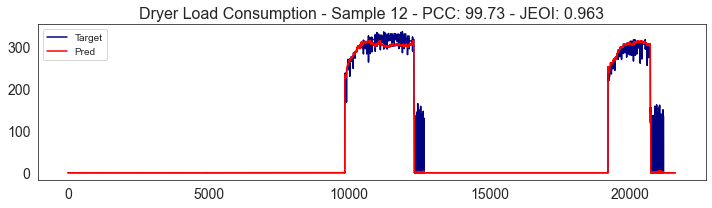

In [ ]:
# Plot
data_shape = X_Test.shape
i = random.randint(0, data_shape[0])
# i = 0
print(i)
plt.figure(figsize=(10,3))
plt.subplot(1,1,1)
# Subplot 1 Data
Y_Test_Temp = np.expand_dims(np.expand_dims(Y_Test_Denorm[i,:,0], axis=0), axis=2)
Y_Pred_Temp = np.expand_dims(np.expand_dims(Y_Pred_Denorm[i,:,0], axis=0), axis=2)
print(Y_Test_Temp.shape)
MAE, MSE, RMSE, PCC = Construction_Error(Y_Test_Temp, Y_Pred_Temp)
SAE = Calculate_SAE(Y_Test_Temp, Y_Pred_Temp)
JEOI = Calculate_JEOI(Y_Test_Temp, Y_Pred_Temp)
#
plt.plot(Y_Test_Temp.ravel(), label='Target', color='navy')
plt.plot(Y_Pred_Temp.ravel(), label='Pred', color='red')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f"Dryer Load Consumption - Sample {i} - PCC: {PCC} - JEOI: {JEOI}", fontdict={'fontsize': 16})
plt.legend()
plt.tight_layout()

# Measure Inference Time

In [39]:
print(X_Test.shape)

(76, 21600, 3)


In [44]:
# Timing utility
import keras
from timeit import default_timer as timer
# Configurations
Total_time = 0.0
N_steps = 1000
# Load Model
model = None
model_path = 'trained_models/LDNet/LDNet_21600_32_3_1.keras'
model = keras.saving.load_model(model_path)
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
total_params = trainable_params + non_trainable_params
print(f'Model name: LD-Net')
print(f'Trainable Params: {trainable_params}')
print(f'Non-trainable Params: {non_trainable_params}')
print(f'Total Params: {total_params}\n')
# preprocessing. mean and std from ImageNet
# Load Sample Image as Input Data
tensor = X_Test[0:1,:,:]
# ensor = tf.convert_to_tensor(sample_signal)  # convert image to tensor
# tensor = tensor.unsqueeze(0)  # reshape 4D tensor (N, C, H, W)
# tensor = tensor.to(device='cuda')
# print(tensor.size())
for i in range(N_steps):
    input_time = timer()
    out = model(tensor) 
    output_time = timer() 
    output_time = output_time - input_time
    Total_time = Total_time + output_time
    del out
print(f'Total Inference Time: {((Total_time*1000)/N_steps):.4} ms')

Model name: UNetPP_from_Scratch
Trainable Params: 17993666
Non-trainable Params: 21248
Total Params: 18014914

Total Inference Time: 470.4 ms


# Infinite Loop to Keep the Tab Alive

In [ ]:
while True:
    pass